Where the actual experiment happens!

In [1]:
%cd /content
!git clone https://github.com/steinburglar/REAN
%cd /content/REAN


/content
fatal: destination path 'REAN' already exists and is not an empty directory.
/content/REAN


In [11]:
!rm -rf runs/*

In [3]:
#do necessary imports
from pathlib import Path
import sys
import torch
import json
import torch.nn as nn
import torch.optim as optim
from rean.utils import make_run_dir, to_serializable
from rean.data.Dataset import make_datasets
from rean.models.CNN import PlainCNN
from rean.models.P4 import P4CNN
from rean.models.RelaxedP4 import RelaxedP4CNN
from rean.train import train_full, evaluate
from rean.plot import LossPlot
import matplotlib.pyplot as plt


In [37]:
#some params that should be the same across all experimental runs

group_order = 4
hidden_dim = 20 #from cohen
out_channels = hidden_dim
classes = 10
kernel_size = 3
num_gconvs = 6 #from cohen
num_epochs = 40
batch_size = 64 #leave this
learning_rate = 0.002 #0.002 is final
gamma = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



cuda


# Experiment Running Loop #

In [38]:
#test full loop
models = ['P4CNN', 'RelaxedP4CNN']
noise_types = ['none', 'iso', 'aniso']
stds = [0.1, 0.2]



#for hyperparameter testing
models = ["PlainCNN"]
noise_types = ['iso']
stds = [0.1]

In [39]:
for model_name in models:
    for noise_type in noise_types:
        for i, std in enumerate(stds):
            if noise_type == 'none':
                if i != 0: #only run noiseless once
                    continue
                train_noise = None
                noise_params = {"mean":0, "std":0, 'gamma':0}

            else:
                train_noise = noise_type
                test_noise = noise_type #could be none?
                noise_params = {'mean': 0, 'std': std, 'gamma': gamma}
            #make datasets
            train_ds, val_ds, test_ds, in_channels = make_datasets(train_noise=train_noise,
                                                            noise_params=noise_params,
                                                            group_order=group_order)
            #train model
            run_data, best_model = train_full(model_name=model_name,
                          train_ds=train_ds,
                          val_ds=val_ds,
                          in_channels=in_channels,
                          hidden_dim=hidden_dim,
                          out_channels=out_channels,
                          classes=classes,
                          num_gconvs=num_gconvs,
                          kernel_size=kernel_size,
                          group_order=group_order,
                          num_epochs=num_epochs,
                          batch_size=batch_size,
                          learning_rate=learning_rate,
                          device=device)
            run_data['noise_type'] = noise_type
            run_data['std'] = std
            run_data['gamma'] = gamma
            run_data['group_order'] = group_order

            run_dir = make_run_dir(model_name, noise_type, noise_params = noise_params, learning_rate = learning_rate)
            with open(run_dir / "run_data.json", "w") as f:
                json.dump(run_data, f, default = to_serializable, indent=2)

            #test the model
            test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, pin_memory =True)
            criterion = nn.CrossEntropyLoss()
            test_loss, test_acc = evaluate(best_model,  device, test_loader, criterion = criterion)
            test = {
                "test_loss": test_loss,
                "test_acc": test_acc
            }
            print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")
            with open(run_dir / "test_data.json", "w") as f:
                json.dump(test, f, default = to_serializable, indent=2)



Epoch 1/40, Train Loss: 1.9308, Val Loss: 1.9074, Val Acc: 28.12%
Epoch 2/40, Train Loss: 1.5109, Val Loss: 1.1298, Val Acc: 58.57%
Epoch 3/40, Train Loss: 1.0610, Val Loss: 1.0199, Val Acc: 62.55%
Epoch 4/40, Train Loss: 0.9121, Val Loss: 0.8398, Val Acc: 71.28%
Epoch 5/40, Train Loss: 0.7771, Val Loss: 0.7748, Val Acc: 73.05%
Epoch 6/40, Train Loss: 0.6496, Val Loss: 0.5622, Val Acc: 81.38%
Epoch 7/40, Train Loss: 0.5711, Val Loss: 0.5149, Val Acc: 82.85%
Epoch 8/40, Train Loss: 0.5108, Val Loss: 0.4529, Val Acc: 85.72%
Epoch 9/40, Train Loss: 0.4449, Val Loss: 0.4481, Val Acc: 86.67%
Epoch 10/40, Train Loss: 0.4051, Val Loss: 0.4639, Val Acc: 85.56%
Epoch 11/40, Train Loss: 0.3828, Val Loss: 0.3638, Val Acc: 88.29%
Epoch 12/40, Train Loss: 0.3589, Val Loss: 0.3266, Val Acc: 89.77%
Epoch 13/40, Train Loss: 0.3464, Val Loss: 0.3393, Val Acc: 89.28%
Epoch 14/40, Train Loss: 0.3277, Val Loss: 0.3381, Val Acc: 89.12%
Epoch 15/40, Train Loss: 0.3131, Val Loss: 0.3119, Val Acc: 90.58%
Epoc

lr = 0.001, at 10 epochs, : Test Loss: 0.4906219344139099, Test Acc: 84.84

lr = 0.002m at 10 epochs: Test Loss: 0.
45190090165138247, Test Acc: 85.13

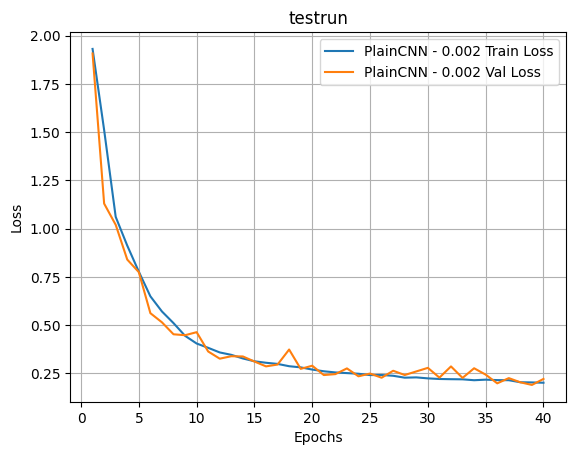

In [40]:
figure, axes = plt.subplots(1, 1)


plot = LossPlot(axes, [run_data], "testrun", ["model_name", "learning_rate"])